# Simple feed forward NN to predict IC50 based on patient demographic and molecular drug information (INCLUDES CELL LINE FEATURE IN TRAINING)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time as time
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
valid_IC50s = pd.read_csv("valid_IC50s_within_range.csv")
merged_df = pd.read_csv("final_merged.csv")
lucas_df = pd.read_csv("final_mapping.csv")
cell_lines_df = pd.read_csv("data/HarvardCellLines.csv")

In [213]:
valid_IC50s

,Unnamed: 0,Cell Name,Small Molecule Name,EC50 (uM),N Points
0,0,BT-20,A-1210477,0.005488,9
1,2,BT-20,AZD7762,1.650602,9
2,5,BT-20,Bleomycin,0.754695,9
3,6,BT-20,Buparlisib,1.336570,9
4,7,BT-20,Cabozantinib,3.789538,9
...,...,...,...,...,...
821,1185,T47D,Topotecan,0.006967,9
822,1186,T47D,Torin2,0.004775,9
823,1187,T47D,Trametinib,0.005605,9
824,1188,T47D,Volasertib,0.033216,9


In [215]:
cell_lines_df

,HMS LINCS Batch ID,HMS LINCS ID,Name,Alternative Names,LINCS ID,Alternative ID,Reference Source,Organism,Organ,Tissue,...,Provider,Provider Catalog ID,Provider Batch ID,Source Information,Date Received,HMS QC Outcome,Transient Modification(s),Date Publicly Available,Most Recent Update,T Stage
0,50008-2,50008,CAL-51,NaN,LCL-1472,"<a href = ""http://purl.obolibrary.org/obo/CLO_...","<a href = ""https://www.dsmz.de/catalogues/deta...",Homo sapiens,breast,NaN,...,Leibniz Institute DSMZ-German Collection of Mi...,ACC-302,NaN,Obtained by Caitlin Mills (Harvard Medical Sch...,NaN,NaN,NaN,4/25/12,8/24/16,4.0
1,50029-2,50029,MCF7,NaN,LCL-1460,"<a href = ""http://purl.obolibrary.org/obo/CLO_...","<a href = ""http://www.atcc.org/Products/All/HT...",Homo sapiens,breast,NaN,...,ATCC,HTB-22,NaN,Obtained by Mario Niepel (Harvard Medical Scho...,7/16/10,PASS,NaN,4/25/12,4/4/16,4.0
2,50056-1,50056,HME1,hTERT-HME1,LCL-2083,"<a href = ""http://purl.obolibrary.org/obo/CLO_...","<a href = ""http://www.atcc.org/Products/All/CR...",Homo sapiens,breast,NaN,...,ATCC,CRL-4010,NaN,Obtained by Mario Niepel (Harvard Medical Scho...,3/2/12,PASS,NaN,5/1/12,7/12/16,0.0
3,50057-2,50057,SK-BR-3,SKBr3,LCL-1475,"<a href = ""http://purl.obolibrary.org/obo/CLO_...","<a href = ""http://www.atcc.org/Products/All/HT...",Homo sapiens,breast,NaN,...,ATCC,HTB-30,NaN,Obtained by Mario Niepel (Harvard Medical Scho...,7/16/10,PASS,NaN,5/1/12,7/12/16,4.0
4,50058-2,50058,MDA-MB-231,MDAMB231; MDA-MB231,LCL-1461,"<a href = ""http://purl.obolibrary.org/obo/CLO_...","<a href = ""http://www.atcc.org/Products/All/HT...",Homo sapiens,breast,NaN,...,ATCC,HTB-26,NaN,Obtained by Mario Niepel (Harvard Medical Scho...,7/16/10,PASS,NaN,5/1/12,7/12/16,4.0
5,50105-2,50105,BT-20,NaN,LCL-1476,"<a href = ""http://purl.obolibrary.org/obo/CLO_...","<a href = ""http://www.atcc.org/Products/All/HT...",Homo sapiens,breast,NaN,...,ATCC,HTB-19,NaN,Obtained by Mario Niepel (Harvard Medical Scho...,7/16/10,PASS,NaN,7/31/12,4/4/16,4.0
6,50108-2,50108,BT-549,NaN,LCL-1310,"<a href = ""http://purl.obolibrary.org/obo/CLO_...","<a href = ""http://www.atcc.org/Products/All/HT...",Homo sapiens,breast,NaN,...,ATCC,HTB-122,NaN,Obtained by Mario Niepel (Harvard Medical Scho...,7/16/10,NaN,NaN,7/31/12,4/4/16,4.0
7,50131-2,50131,CAMA-1,NaN,LCL-1466,"<a href = ""http://purl.obolibrary.org/obo/CLO_...","<a href = ""http://www.atcc.org/Products/All/HT...",Homo sapiens,breast,NaN,...,ATCC,HTB-21,NaN,Obtained by Mario Niepel (Harvard Medical Scho...,7/16/10,NaN,NaN,7/31/12,4/4/16,4.0
8,50205-2,50205,HCC1143,NaN,LCL-1329,"<a href = ""http://purl.obolibrary.org/obo/CLO_...","<a href = ""http://www.atcc.org/Products/All/CR...",Homo sapiens,breast,NaN,...,ATCC,CRL-2321,NaN,"Received from Kristin Brown (Alex Toker Lab, B...",NaN,NaN,NaN,7/31/12,4/4/16,2.0
9,50206-2,50206,HCC1395,HCC-1395,LCL-1330,"<a href = ""http://purl.obolibrary.org/obo/CLO_...","<a href = ""http://www.atcc.org/Products/All/CR...",Homo sapiens,breast,NaN,...,ATCC,CRL-2324,NaN,Obtained by Mario Niepel (Harvard Medical Scho...,7/16/10,NaN,NaN,7/31/12,4/4/16,1.0


In [217]:
lucas_df

,Patient ID,Matched Cell Line ID,Similarity Distance
0,Breast_MRI_001,50579-1,1.161047
1,Breast_MRI_002,50579-1,1.428981
2,Breast_MRI_003,50205-2,0.893113
3,Breast_MRI_004,50206-2,1.339669
4,Breast_MRI_005,50207-2,1.458638
...,...,...,...
3426,MTS-T2428,50029-2,1.417031
3427,MTS-T2429,50205-2,0.982424
3428,MTS-T2430,50056-1,0.893113
3429,MTS-T2431,50056-1,0.893113


In [219]:
valid_IC50s.drop(columns = ['Unnamed: 0', 'N Points'], inplace = True)

In [221]:
cell_lines_df.columns

Index(['HMS LINCS Batch ID', 'HMS LINCS ID', 'Name', 'Alternative Names',
       'LINCS ID', 'Alternative ID', 'Reference Source', 'Organism', 'Organ',
       'Tissue', 'Cell Type', 'Details of Cell Type', 'Donor Sex', 'Donor Age',
       'Donor Ethnicity', 'Donor Health Status', 'Disease', 'Unnamed: 17',
       'Details of Disease', 'Production Details', 'Genetic Modification(s)',
       'Known Mutations', 'Citation Information for Mutations',
       'Verification Reference Profile', 'Growth Properties',
       'Recommended Culture Conditions', 'Relevant Citations', 'Usage Note',
       'Comments', 'Provider', 'Provider Catalog ID', 'Provider Batch ID',
       'Source Information', 'Date Received', 'HMS QC Outcome',
       'Transient Modification(s)', 'Date Publicly Available',
       'Most Recent Update', 'T Stage'],
      dtype='object')

In [223]:
columns = ["HMS LINCS ID", "Name", "T Stage"]
cell_lines_df = cell_lines_df[columns]

In [225]:
merged_df["Race"].value_counts()

Race
1.0    5857
2.0     470
4.0     321
0.0      19
5.0      18
3.0      14
6.0       9
8.0       4
7.0       1
Name: count, dtype: int64

In [227]:
# # TEMPORARY IMPUTATION OF RACE BASED OFF PROPORTIONS OF EXISTING RACES.
# # WILL USE AUSTIN'S IMPUTED RACE ANALYSIS LATER.

# # Get value counts as probabilities
# race_dist = merged_df['Race'].value_counts(normalize=True)

# # Get the indices where race is missing
# missing_indices = lucas_df['Cell_Line_Race'].isna()

# # Sample values based on observed distribution
# imputed_values = np.random.choice(race_dist.index, size=missing_indices.sum(), p=race_dist.values)

# # Assign the sampled values to the missing positions
# lucas_df.loc[missing_indices, 'Cell_Line_Race'] = imputed_values


In [229]:
# TEMPORARY IMPUTATION OF RACE BASED OFF PROPORTIONS OF EXISTING RACES.
# WILL USE AUSTIN'S IMPUTED RACE ANALYSIS LATER.

# Get value counts as probabilities
race_dist = merged_df['Race'].value_counts(normalize=True)

# Get the indices where race is missing
missing_indices = merged_df['Race'].isna()

# Sample values based on observed distribution
imputed_values = np.random.choice(race_dist.index, size=missing_indices.sum(), p=race_dist.values)

# Assign the sampled values to the missing positions
merged_df.loc[missing_indices, 'Race'] = imputed_values

In [231]:
def T_stage_by_size(size):
    if size == 0:
        return 0
    if size > 0 and size <= 20:
        return 1
    if size > 20 and size <= 50:
        return 2
    if size > 50:
        return 3

In [233]:
merged_df['T_stage_by_size'] = merged_df.apply(lambda row: row['T Stage'] if pd.notnull(row['T Stage']) else T_stage_by_size(row['Tumor Size']), axis=1)

In [235]:
merged_df['T_stage_by_size'].isna().sum()

134

In [237]:
columns = ['Age', 'Race', 'T_stage_by_size']
patients_df = merged_df[columns]

In [239]:
patients_df

,Age,Race,T_stage_by_size
0,41,2.0,2.0
1,41,2.0,2.0
2,38,2.0,2.0
3,62,1.0,2.0
4,62,1.0,2.0
...,...,...,...
9217,69,1.0,4.0
9218,69,1.0,4.0
9219,69,1.0,4.0
9220,69,1.0,4.0


In [241]:
patients_df.isna().sum()

Age                  0
Race                 0
T_stage_by_size    134
dtype: int64

In [243]:
valid_IC50s

,Cell Name,Small Molecule Name,EC50 (uM)
0,BT-20,A-1210477,0.005488
1,BT-20,AZD7762,1.650602
2,BT-20,Bleomycin,0.754695
3,BT-20,Buparlisib,1.336570
4,BT-20,Cabozantinib,3.789538
...,...,...,...
821,T47D,Topotecan,0.006967
822,T47D,Torin2,0.004775
823,T47D,Trametinib,0.005605
824,T47D,Volasertib,0.033216


# USE LUCAS' DATASET STARTING HERE

In [246]:
def get_biased_cell_lines(patient_row, cell_line_df, n=3):
    # Filter for matching T_stage
    filtered = cell_line_df[cell_line_df["T Stage"] == patient_row["T_stage_by_size"]]

    # If fewer than n matches, fall back to all cell lines
    if len(filtered) < n:
        filtered = cell_line_df

    return np.random.choice(filtered["HMS LINCS ID"], size=n, replace=False).tolist()

In [248]:
patients_df["T_stage_by_size"].apply(type).value_counts()

T_stage_by_size
<class 'float'>    9222
Name: count, dtype: int64

In [250]:
cell_lines_df["T Stage"].apply(type).value_counts()

T Stage
<class 'float'>    35
Name: count, dtype: int64

In [252]:
# Add a list of 3 biased cell lines per patient
patients_df["cell_lines"] = patients_df.apply(lambda row: get_biased_cell_lines(row, cell_lines_df), axis=1)


/var/folders/s8/ghqk1l4n7n9_w17t7hx21g2m0000gn/T/ipykernel_6359/1392642400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients_df["cell_lines"] = patients_df.apply(lambda row: get_biased_cell_lines(row, cell_lines_df), axis=1)


In [254]:
patients_df

,Age,Race,T_stage_by_size,cell_lines
0,41,2.0,2.0,"[50205, 50213, 50579]"
1,41,2.0,2.0,"[50579, 50216, 50211]"
2,38,2.0,2.0,"[50212, 50579, 50213]"
3,62,1.0,2.0,"[50216, 50211, 50205]"
4,62,1.0,2.0,"[50579, 50213, 50216]"
...,...,...,...,...
9217,69,1.0,4.0,"[50058, 50208, 50105]"
9218,69,1.0,4.0,"[50331, 50058, 50335]"
9219,69,1.0,4.0,"[50238, 50029, 51112]"
9220,69,1.0,4.0,"[50541, 51081, 51083]"


In [256]:
# Explode so each row = 1 (patient, cell_line)
patients_df = patients_df.explode("cell_lines").reset_index(drop=True)

In [258]:
cell_lines_df_dict = cell_lines_df.set_index("HMS LINCS ID").to_dict()["Name"]
display(cell_lines_df_dict)

def cell_name_map(row, dictionary):
    return dictionary[row]

{50008: 'CAL-51',
 50029: 'MCF7',
 50056: 'HME1',
 50057: 'SK-BR-3',
 50058: 'MDA-MB-231',
 50105: 'BT-20',
 50108: 'BT-549',
 50131: 'CAMA-1',
 50205: 'HCC1143',
 50206: 'HCC1395',
 50207: 'HCC1419',
 50208: 'HCC1428',
 50211: 'HCC1806',
 50212: 'HCC1937',
 50213: 'HCC1954',
 50216: 'HCC38',
 50219: 'HCC70',
 50238: 'Hs 578T',
 50327: 'MDA-MB-134-VI',
 50328: 'MDA-MB-157',
 50331: 'MDA-MB-361',
 50333: 'MDA-MB-436',
 50334: 'MDA-MB-453',
 50335: 'MDA-MB-468',
 50541: 'T47D',
 50579: 'HCC1500',
 50583: 'MCF 10A',
 51081: 'SUM1315MO2',
 51082: 'SUM149PT',
 51083: 'SUM159PT',
 51110: 'CAL-120',
 51112: 'CAL-85-1',
 51134: 'PDX1258',
 51135: 'PDX1328',
 51136: 'PDXHCI002'}

In [260]:
patients_df["Cell Name"] = patients_df["cell_lines"].apply(cell_name_map, dictionary = cell_lines_df_dict)

In [262]:
patients_df

,Age,Race,T_stage_by_size,cell_lines,Cell Name
0,41,2.0,2.0,50205,HCC1143
1,41,2.0,2.0,50213,HCC1954
2,41,2.0,2.0,50579,HCC1500
3,41,2.0,2.0,50579,HCC1500
4,41,2.0,2.0,50216,HCC38
...,...,...,...,...,...
27661,69,1.0,4.0,51081,SUM1315MO2
27662,69,1.0,4.0,51083,SUM159PT
27663,69,1.0,4.0,50058,MDA-MB-231
27664,69,1.0,4.0,51081,SUM1315MO2


In [264]:
# ASK TEAM TO HELP IMPUTE MISSING T-STAGE OR DROP THEIR ROWS 
# MAYBE ASK AUSTIN FOR SIMILAR WORKFLOW USED FOR RACE BUT FOR T-STAGE 
patients_df.dropna(inplace=True)
patients_df.isna().sum()

Age                0
Race               0
T_stage_by_size    0
cell_lines         0
Cell Name          0
dtype: int64

# Add Small Molecule descriptors for each row. 

In [267]:
drugs_df = pd.read_csv("Descriptors_Small_Molecules.csv")
drugs_df = drugs_df[['Name', 'Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']]
drugs_df.rename(columns={'Name': 'Small Molecule Name'}, inplace=True)
drugs_df.head()

,Small Molecule Name,Molecular Mass,LogP,NumHDonors,NumHAcceptors,TPSA
0,AZD7762,362.12,2.52660,4,4,96.25
1,Neratinib,556.20,5.93248,2,8,112.40
2,Dasatinib,487.16,3.31354,3,9,106.51
3,Saracatinib,541.21,3.93950,1,10,90.44
4,Pictilisib,513.16,2.14840,1,9,107.55


In [269]:
valid_IC50s.columns

Index(['Cell Name', 'Small Molecule Name', 'EC50 (uM)'], dtype='object')

In [271]:
valid_IC50s = pd.merge(valid_IC50s, drugs_df, on='Small Molecule Name', how='left')

In [273]:
valid_IC50s.head(3)

,Cell Name,Small Molecule Name,EC50 (uM),Molecular Mass,LogP,NumHDonors,NumHAcceptors,TPSA
0,BT-20,A-1210477,0.005488,849.39,6.05282,1,11,134.84
1,BT-20,AZD7762,1.650602,362.12,2.52660,4,4,96.25
2,BT-20,Bleomycin,0.754695,1414.52,-7.70358,20,31,627.07


In [275]:
patients_df.head(3)

,Age,Race,T_stage_by_size,cell_lines,Cell Name
0,41,2.0,2.0,50205,HCC1143
1,41,2.0,2.0,50213,HCC1954
2,41,2.0,2.0,50579,HCC1500


In [277]:
patient_drug_df = pd.merge(patients_df, valid_IC50s, on='Cell Name', how='left')

In [279]:
patient_drug_df.drop(columns = "cell_lines", inplace=True)

In [281]:
patient_drug_df.to_csv("patient_drug_information_aka_final_final_final.csv")

In [282]:
patient_drug_df

,Age,Race,T_stage_by_size,Cell Name,Small Molecule Name,EC50 (uM),Molecular Mass,LogP,NumHDonors,NumHAcceptors,TPSA
0,41,2.0,2.0,HCC1143,A-1210477,3.428964,849.39,6.05282,1,11,134.84
1,41,2.0,2.0,HCC1143,AZD7762,0.055766,362.12,2.52660,4,4,96.25
2,41,2.0,2.0,HCC1143,Abemaciclib,0.085608,506.27,4.93692,1,8,75.00
3,41,2.0,2.0,HCC1143,Alpelisib,4.108150,441.14,3.83502,2,5,101.21
4,41,2.0,2.0,HCC1143,Bleomycin,0.065912,1414.52,-7.70358,20,31,627.07
...,...,...,...,...,...,...,...,...,...,...,...
653382,69,1.0,4.0,SUM159PT,Topotecan,0.024432,421.16,1.84680,2,8,104.89
653383,69,1.0,4.0,SUM159PT,Torin2,0.011539,432.12,5.20190,1,5,73.80
653384,69,1.0,4.0,SUM159PT,Trametinib,0.002193,615.08,3.94012,2,8,107.13
653385,69,1.0,4.0,SUM159PT,Volasertib,0.024222,618.40,4.26720,2,9,106.17


In [283]:
race_dict = {0:'N/A', 1:"white", 2:"black", 3:"asian", 4:"native", 5:"hispanic", 6:"multi", 7:"hawa", 8:"amer indian"}

def race_map(row, dictionary):
    return dictionary[row]

In [284]:
patient_drug_df["Race"] = patient_drug_df["Race"].apply(race_map, dictionary = race_dict)

In [285]:
patient_drug_df

,Age,Race,T_stage_by_size,Cell Name,Small Molecule Name,EC50 (uM),Molecular Mass,LogP,NumHDonors,NumHAcceptors,TPSA
0,41,black,2.0,HCC1143,A-1210477,3.428964,849.39,6.05282,1,11,134.84
1,41,black,2.0,HCC1143,AZD7762,0.055766,362.12,2.52660,4,4,96.25
2,41,black,2.0,HCC1143,Abemaciclib,0.085608,506.27,4.93692,1,8,75.00
3,41,black,2.0,HCC1143,Alpelisib,4.108150,441.14,3.83502,2,5,101.21
4,41,black,2.0,HCC1143,Bleomycin,0.065912,1414.52,-7.70358,20,31,627.07
...,...,...,...,...,...,...,...,...,...,...,...
653382,69,white,4.0,SUM159PT,Topotecan,0.024432,421.16,1.84680,2,8,104.89
653383,69,white,4.0,SUM159PT,Torin2,0.011539,432.12,5.20190,1,5,73.80
653384,69,white,4.0,SUM159PT,Trametinib,0.002193,615.08,3.94012,2,8,107.13
653385,69,white,4.0,SUM159PT,Volasertib,0.024222,618.40,4.26720,2,9,106.17


### Cell lines are proxy for patients, so drop the cell lines column. 

In [292]:
# patient_drug_df.drop(columns="Cell Name", inplace=True)

### Need to one-hot-encode categorical featurs

In [304]:
categorical_cols = ['Race', 'T_stage_by_size', 'Small Molecule Name', 'Cell Name']
patient_drug_df[categorical_cols] = patient_drug_df[categorical_cols].astype('category')

In [306]:
patient_drug_df_encoded = pd.get_dummies(patient_drug_df, columns=categorical_cols, drop_first=True)
print(patient_drug_df_encoded.dtypes)

Age                       int64
EC50 (uM)               float64
Molecular Mass          float64
LogP                    float64
NumHDonors                int64
                         ...   
Cell Name_SK-BR-3          bool
Cell Name_SUM1315MO2       bool
Cell Name_SUM149PT         bool
Cell Name_SUM159PT         bool
Cell Name_T47D             bool
Length: 86, dtype: object


In [316]:
bool_cols = patient_drug_df_encoded.select_dtypes(include='bool').columns
patient_drug_df_encoded[bool_cols] = patient_drug_df_encoded[bool_cols].astype(int)

In [318]:
patient_drug_df_encoded.head(3)

,Age,EC50 (uM),Molecular Mass,LogP,NumHDonors,NumHAcceptors,TPSA,Race_amer indian,Race_asian,Race_black,...,Cell Name_MDA-MB-453,Cell Name_MDA-MB-468,Cell Name_PDX1258,Cell Name_PDX1328,Cell Name_PDXHCI002,Cell Name_SK-BR-3,Cell Name_SUM1315MO2,Cell Name_SUM149PT,Cell Name_SUM159PT,Cell Name_T47D
0,41,3.428964,849.39,6.05282,1,11,134.84,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,41,0.055766,362.12,2.52660,4,4,96.25,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,41,0.085608,506.27,4.93692,1,8,75.00,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### PRE-PROCESSING DONE. ONTO MODEL TRAINING.

In [382]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [384]:
# Separate features (X) and target (y)
X = patient_drug_df_encoded.drop(columns=['EC50 (uM)'])  # Drop EC50 and non-features
y = patient_drug_df_encoded['EC50 (uM)']  # EC50 is the target

# Standardize numerical features
scaler = StandardScaler()
X[['Age', 'Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']] = scaler.fit_transform(X[['Age', 'Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']]) 

In [386]:
X

,Age,Molecular Mass,LogP,NumHDonors,NumHAcceptors,TPSA,Race_amer indian,Race_asian,Race_black,Race_hawa,...,Cell Name_MDA-MB-453,Cell Name_MDA-MB-468,Cell Name_PDX1258,Cell Name_PDX1328,Cell Name_PDXHCI002,Cell Name_SK-BR-3,Cell Name_SUM1315MO2,Cell Name_SUM149PT,Cell Name_SUM159PT,Cell Name_T47D
0,-1.347808,1.358929,1.116436,-0.552571,0.436551,0.046012,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,-1.347808,-0.691354,-0.004515,0.263641,-0.827422,-0.305149,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,-1.347808,-0.084815,0.761702,-0.552571,-0.105152,-0.498520,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.347808,-0.358862,0.411419,-0.280501,-0.646854,-0.260014,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,-1.347808,3.736823,-3.256590,4.616772,4.047902,4.525207,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653382,1.318465,-0.442932,-0.220617,-0.280501,-0.105152,-0.226527,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
653383,1.318465,-0.396816,0.845936,-0.552571,-0.646854,-0.509440,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
653384,1.318465,0.373024,0.444829,-0.280501,-0.105152,-0.206143,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
653385,1.318465,0.386994,0.548804,-0.280501,0.075416,-0.214879,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [388]:
y

0         3.428964
1         0.055766
2         0.085608
3         4.108150
4         0.065912
            ...   
653382    0.024432
653383    0.011539
653384    0.002193
653385    0.024222
653386    1.943555
Name: EC50 (uM), Length: 653387, dtype: float64

In [390]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [394]:
# FEED FORWARD NEURAL NETWORK - 2 LAYERS

class DrugEncoder(nn.Module):
    def __init__(self, input_dim=5):  # 5 molecular descriptors
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )

    def forward(self, x):
        return self.encoder(x.float())

# SIMGPLE FEED FORWARD NEURAL NETWORK 
class PatientEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )

    def forward(self, x):
        return self.encoder(x.float())

# REGRESSION PREDICTION WITH SIMPLE FEED FORWARD NEURAL NETWORK

class DrugResponsePredictor(nn.Module):
    def __init__(self, drug_input_dim, patient_input_dim):
        super().__init__()
        self.drug_encoder = DrugEncoder(drug_input_dim)
        self.patient_encoder = PatientEncoder(patient_input_dim)
        self.fc = nn.Sequential(
            nn.Linear(32 + 32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # IC50 prediction
        )

    def forward(self, drug_feat, patient_feat):
        drug_vec = self.drug_encoder(drug_feat)
        patient_vec = self.patient_encoder(patient_feat)
        combined = torch.cat([drug_vec, patient_vec], dim=1)
        return self.fc(combined).squeeze(-1)


In [396]:
# Data
# Select drug descriptor columns
drug_feature_cols = ['Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']
drug_features = X_train[drug_feature_cols].to_numpy()  # (n_samples, 5)

# Drop drug features to get patient features
patient_features = X_train.drop(columns=drug_feature_cols).to_numpy()

# Convert to tensors
drug_tensor = torch.tensor(drug_features).float()
patient_tensor = torch.tensor(patient_features).float()
ic50_tensor = torch.tensor(y_train.to_numpy()).float()

model = DrugResponsePredictor(drug_input_dim=5, patient_input_dim=patient_tensor.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


# Training loop
model.train()
start_time = time.time()

for epoch in range(300):  
    optimizer.zero_grad()
    preds = model(drug_tensor, patient_tensor)
    loss = loss_fn(preds, ic50_tensor)
    loss.backward()
    optimizer.step()
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Epoch {epoch} | Loss: {loss.item():.4f}")
    print(f"Time elapsed: {elapsed:.2f} seconds")


Epoch 0 | Loss: 4.1187
Time elapsed: 0.11 seconds
Epoch 1 | Loss: 4.0573
Time elapsed: 0.22 seconds
Epoch 2 | Loss: 4.0004
Time elapsed: 0.33 seconds
Epoch 3 | Loss: 3.9478
Time elapsed: 0.44 seconds
Epoch 4 | Loss: 3.8985
Time elapsed: 0.55 seconds
Epoch 5 | Loss: 3.8509
Time elapsed: 0.66 seconds
Epoch 6 | Loss: 3.8046
Time elapsed: 0.77 seconds
Epoch 7 | Loss: 3.7590
Time elapsed: 0.88 seconds
Epoch 8 | Loss: 3.7139
Time elapsed: 0.99 seconds
Epoch 9 | Loss: 3.6695
Time elapsed: 1.10 seconds
Epoch 10 | Loss: 3.6255
Time elapsed: 1.21 seconds
Epoch 11 | Loss: 3.5820
Time elapsed: 1.32 seconds
Epoch 12 | Loss: 3.5391
Time elapsed: 1.43 seconds
Epoch 13 | Loss: 3.4963
Time elapsed: 1.54 seconds
Epoch 14 | Loss: 3.4536
Time elapsed: 1.65 seconds
Epoch 15 | Loss: 3.4109
Time elapsed: 1.76 seconds
Epoch 16 | Loss: 3.3684
Time elapsed: 1.87 seconds
Epoch 17 | Loss: 3.3263
Time elapsed: 1.98 seconds
Epoch 18 | Loss: 3.2849
Time elapsed: 2.09 seconds
Epoch 19 | Loss: 3.2442
Time elapsed: 2.2

In [397]:
def evaluate_model(model, drug_features, patient_features, true_ic50s):
    # Convert to numpy if needed
    if hasattr(drug_features, 'to_numpy'):
        drug_features = drug_features.to_numpy()
    if hasattr(patient_features, 'to_numpy'):
        patient_features = patient_features.to_numpy()
    if hasattr(true_ic50s, 'to_numpy'):
        true_ic50s = true_ic50s.to_numpy()

    # Convert to tensors
    drug_tensor = torch.tensor(drug_features).float()
    patient_tensor = torch.tensor(patient_features).float()
    true_ic50_tensor = torch.tensor(true_ic50s).float()

    # Inference
    model.eval()
    with torch.no_grad():
        preds = model(drug_tensor, patient_tensor).cpu().numpy()
        targets = true_ic50_tensor.cpu().numpy()

    # Metrics
    mse = mean_squared_error(targets, preds)
    mae = mean_absolute_error(targets, preds)
    r2 = r2_score(targets, preds)

    return mse, mae, r2


In [400]:
drug_features_test = X_test[['Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']]
patient_features_test = X_test.drop(columns=drug_features_test.columns)

metrics = evaluate_model(model, drug_features_test, patient_features_test, y_test)

print(f"MSE: {metrics[0]:.4f}")
print(f"MAE: {metrics[1]:.4f}")
print(f"R²: {metrics[2]:.4f}")


MSE: 0.0586
MAE: 0.1118
R²: 0.9811


In [434]:
def plot_pred_vs_true(true, preds):
    plt.figure(figsize=(8, 6))
    plt.scatter(true, preds, alpha=0.6, label='Predictions')
    
    # Ideal line
    plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--', label='Ideal')

    # Trendline (best fit)
    slope, intercept = np.polyfit(true, preds, 1)
    plt.plot(true, slope * true + intercept, 'g-', label='Best Fit Line')

    plt.xlabel("True IC50")
    plt.ylabel("Predicted IC50")
    plt.title("True vs. Predicted IC50 values\nModel trained with 300 epochs")
    plt.legend()
    plt.tight_layout()
    plt.show()

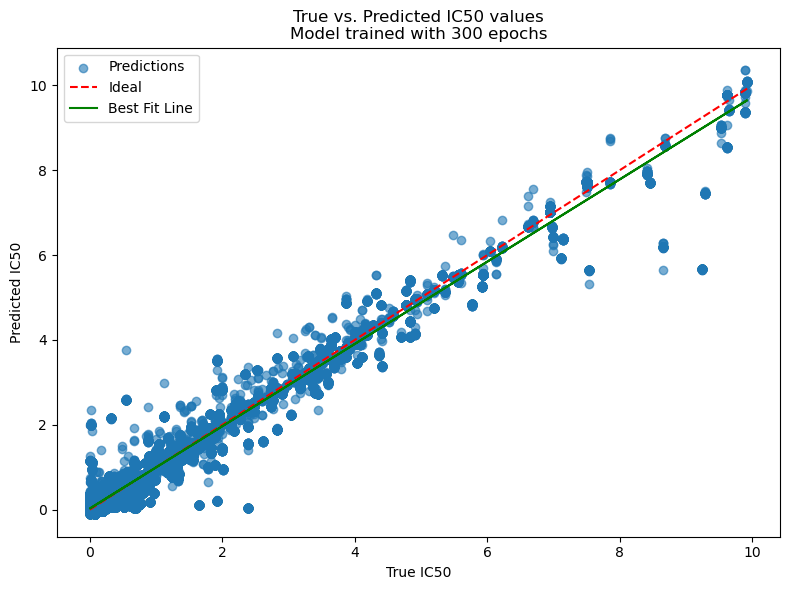

In [436]:
with torch.no_grad():
    preds = model(torch.tensor(drug_features_test.values).float(),
                  torch.tensor(patient_features_test.values).float()).cpu().numpy()
plot_pred_vs_true(y_test.to_numpy(), preds)

In [407]:
y_train.value_counts()

EC50 (uM)
0.017377    2092
0.010267    2077
0.014107    2076
0.001742    2074
0.009191    2073
            ... 
3.243004     232
3.927414     232
0.008984     231
0.011958     231
0.002345     226
Name: count, Length: 826, dtype: int64